### Dataset
Download the MNIST dataset into local memory; this is used to implement the custom Dataset and DataLoader classes.

In [1]:
!rm -rf mnist_data
!mkdir mnist_data
%cd mnist_data

!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

!gunzip *.gz
%cd ..

/Users/akshatgupta/Desktop/IIITD/SEM_6/DL/DL-Assignments/Assignment1/mnist_data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  2465k      0  0:00:03  0:00:03 --:--:-- 2465k 0:00:13  0:00:02  0:00:11  712k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0  42948      0 --:--:-- --:--:-- --:--:-- 42913
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  1085k      0  0:00:01  0:00:01 --:--:-- 1085k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  454

### Transform 
This is the Transform function used for the custom DataLoader class.

In [2]:
import torch

def tensor_transform(data):
    data = torch.from_numpy(data).to(torch.float32)
    data = torch.div(data,255.0)
    return data

### CustomDataSet Class
This is the implementation of the custom Dataset class that returns a dataset object.

In [3]:
import os, struct
import numpy as np


class CustomDataset:
    def __init__(self,root,train=True):
        """
        Args:
            root (str): path to the directory of the dataset
            train (bool, default=True): if True return training data, else return testing data
        """
        self.root = root
        self.train = train

        self.data_name = ('train-images-idx3-ubyte' if train else 't10k-images-idx3-ubyte')
        self.labels_name = ('train-labels-idx1-ubyte' if train else 't10k-labels-idx1-ubyte')
        self.data, self.labels = self.load_data()


    def load_data(self):
        data_path = os.path.join(self.root, self.data_name)
        labels_path = os.path.join(self.root, self.labels_name)

        with open(data_path, 'rb') as f:
            _, _, rows, cols = struct.unpack('>IIII', f.read(16))
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(-1, 1, rows, cols)
        with open(labels_path, 'rb') as f:
            _, _ = struct.unpack('>II', f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)

        return data, labels


    def __len__(self):
        return len(self.data)


    def __getitem__(self,index):
        img, target = list(self.data[index]), int(self.labels[index])
        return img, target

### CustomDataLoader Class
This is the implementation of the custom DataLoader class that loads the MNIST dataset batch-wise as a dictionary with "data" indicating the image data, and "label" indicating the label of each corresponding sample.

In [4]:
class CustomDataLoader:
    def __init__(self,dataset,batch_size=64,shuffle=False,transform=None):
        """
        Args:
            dataset (obj): Dataset object that will be loaded into the stream; must implement __getitem__ and __len__ functions
            batch_size (int, default=64): batch size
            shuffle (bool, default=False): if True shuffles the data before loading into stream
            transform (callable, default=None): transform function to apply to data
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transform = transform
        self.num_samples = len(dataset)
        self.num_batches = (self.num_samples + batch_size - 1) // batch_size

    def __iter__(self):
        if self.shuffle:
            indices = torch.randperm(self.num_samples)
        else:
            indices = torch.arange(self.num_samples)

        for i in range(0, self.num_samples, self.batch_size):
            batch_indices = indices[i:min(self.num_samples,i+self.batch_size)]
            batch = [self.dataset[index] for index in batch_indices]
            batch = tuple(zip(*batch))
            data, label = batch

            if self.transform is not None:
                data = self.transform(np.array(data))

            yield {'data':data,'label':torch.from_numpy(np.array(label))}

    def __len__(self):
        return self.num_batches

In [5]:
trdata = CustomDataset(
    root="./mnist_data/",
    train=True
)
traindata,valdata = torch.utils.data.random_split(trdata,[50000,10000])
testdata = CustomDataset(
    root="./mnist_data/",
    train=False
)

### Dataset using ```torch.utils.data.Dataset```
This class loads the MNIST dataset using the implementation that PyTorch provides.

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


class MNISTDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.MNIST(root=root, train=True, transform=transform, download=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return {'data': image, 'label': label}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [7]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x:x/255.0)])
mnist_data = MNISTDataset(root="./mnist_data/",transform=transform)

100%|██████████| 9912422/9912422 [00:04<00:00, 2149358.90it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 93468899.56it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1947687.44it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24023365.41it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



### Performance Comparison of DataLoaders
The following blocks of code compare the performance of the CustomDataLoader and the torch.utils.data.DataLoader objects against different batch sizes.

The graph indicates that the CustomDataLoader loads data faster at smaller batch sizes, but is out-performed at larger batch sizes. The mean performance time indicates the CustomDataLoader loads data faster than the torch.utils.data.DataLoader object and is thus used for all further tasks.

In [8]:
import time

def measure_dataloader_time(dataloader):
    start_time = time.time()
    for batch in dataloader:
        data,labels = batch
        print(batch)
        end_time = time.time()
        return end_time - start_time

In [9]:
batch_sizes = [128,256,512,1024]

dataloader_1_times = []
dataloader_2_times = []

for batch_size in batch_sizes:
    dataloader_1 = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=False)
    time_taken = measure_dataloader_time(dataloader_1)
    dataloader_1_times.append(time_taken)

    dataloader_2 = CustomDataLoader(dataset=traindata,batch_size=batch_size,shuffle=False,transform=tensor_transform)
    time_taken = measure_dataloader_time(dataloader_2)
    dataloader_2_times.append(time_taken)

{'data': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,

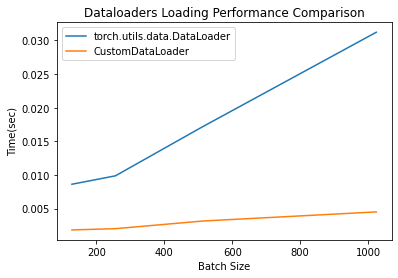

In [10]:
import matplotlib.pyplot as plt

plt.plot(batch_sizes, dataloader_1_times, label='torch.utils.data.DataLoader')
plt.plot(batch_sizes, dataloader_2_times, label='CustomDataLoader')
plt.xlabel('Batch Size')
plt.ylabel('Time(sec)')
plt.title('Dataloaders Loading Performance Comparison')
plt.legend()
plt.show()

In [11]:
dataloader_1_times

[0.008615255355834961,
 0.009865760803222656,
 0.01714920997619629,
 0.031225204467773438]

In [12]:
dataloader_2_times

[0.0018200874328613281,
 0.0020041465759277344,
 0.003139972686767578,
 0.004498958587646484]

In [13]:
np.mean(dataloader_1_times)

0.016713857650756836

In [14]:
np.mean(dataloader_2_times)

0.0028657913208007812

### Feed-Forward NN (FFN)
This is the implementation of the Feed-Forward Neural Network using the PyTorch library functions and classes.

In [15]:
class FeedForwardNN(torch.nn.Module):
    def __init__(self,input_size,hidden_sizes,num_classes,activation='relu',softmax=torch.nn.LogSoftmax(dim=1)):
        super(FeedForwardNN, self).__init__()
        self.layers = torch.nn.ModuleList()

        for i in range(len(hidden_sizes)+1):
            n_in = input_size if i==0 else hidden_sizes[i-1]
            n_out = num_classes if i==len(hidden_sizes) else hidden_sizes[i]

            self.layers.append(torch.nn.Linear(n_in,n_out))
            if i<len(hidden_sizes):
                self.layers.append(torch.nn.Sigmoid(inplace=True) if activation=='sigmoid' else torch.nn.ReLU(inplace=True))
                self.layers.append(torch.nn.BatchNorm1d(num_features=n_out))
            else:
                self.layers.append(softmax)

    
    def forward(self,x):
        X = x
        for layer in self.layers:
            X = layer(X)
        return X

In [16]:
batch_size = 128
input_size = 28*28
hidden_sizes = [512,256,64,32]
num_classes = 10

n_epochs = 60
lr = 0.0003

In [17]:
trainloader = CustomDataLoader(
    traindata,
    batch_size=batch_size,
    shuffle=False,
    transform=tensor_transform
)
valloader = CustomDataLoader(
    valdata,
    batch_size=batch_size,
    shuffle=False,
    transform=tensor_transform
)
testloader = CustomDataLoader(
    testdata,
    batch_size=batch_size,
    shuffle=False,
    transform=tensor_transform
)

In [18]:
model1 = FeedForwardNN(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes
)

loss1 = torch.nn.CrossEntropyLoss()
# loss1 = CustomCrossEntropyLoss(model=model1,n_classes=num_classes)
optimizer1 = torch.optim.SGD(params=model1.parameters(),lr=lr)
# optimizer1 = CustomSGD(model=model1,learning_rate=lr)

### Training the Model
An instance of the FFN is trained with learning rate = 0.0003 for 60 epochs with Cross-Entropy Loss and Stochastic Gradient Descent as the updation policy.

In [19]:
train_loss,test_loss,val_loss,train_acc,test_acc,val_acc = [],[],[],[],[],[]

# mps_device = torch.device('mps')
# model1.to(mps_device)

for epoch in range(n_epochs):
    model1.train(mode=True)
    correct = 0
    n_samples = 0
    total_loss = 0

    for idx,batch in enumerate(trainloader):
        optimizer1.zero_grad()
        data,labels = batch['data'],batch['label']
        # data = data.to(mps_device)
        # labels = labels.to(mps_device)

        inputs = data.view(data.size(0),-1).float()
        outputs = model1(inputs)
        l = loss1(outputs,labels)
        l.backward()
        optimizer1.step()

        _,pred = torch.max(outputs,dim=1)
        correct += (pred==labels).sum().item()
        n_samples += labels.size(0)
        total_loss += l.item()

    avg_train_l = total_loss/len(trainloader)
    train_a = correct/n_samples

    train_loss.append(avg_train_l)
    train_acc.append(train_a)


    model1.train(mode=False)
    correct = 0
    n_samples_test = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(testloader):
            testsamples,testlabels = batch['data'],batch['label']
            # testsamples = testsamples.to(mps_device)
            # testlabels = testlabels.to(mps_device)

            inputs = testsamples.view(testsamples.size(0),-1).float()
            testoutputs = model1(inputs)
            l = loss1(testoutputs,testlabels)

            _,pred = torch.max(testoutputs,dim=1)
            correct += (pred==testlabels).sum().item()
            n_samples_test += len(testlabels)
            total_loss += l.item()

    avg_test_l = total_loss/len(testloader)
    test_a = correct/n_samples_test

    test_loss.append(avg_test_l)
    test_acc.append(test_a)


    model1.train(mode=False)
    correct = 0
    n_samples_val = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(valloader):
            valsamples,vallabels = batch['data'],batch['label']
            # valsamples = valsamples.to(mps_device)
            # vallabels = vallabels.to(mps_device)

            inputs = valsamples.view(valsamples.size(0),-1).float()
            valoutputs = model1(inputs)
            l = loss1(valoutputs,vallabels)

            _,pred = torch.max(valoutputs,dim=1)
            correct += (pred==vallabels).sum().item()
            n_samples_val += len(vallabels)
            total_loss += l.item()

    avg_val_l = total_loss/len(valloader)
    val_a = correct/n_samples_val

    val_loss.append(avg_val_l)
    val_acc.append(val_a)


    print(f"Epoch {epoch+1}/{n_epochs}:\nTrain Loss: {avg_train_l}, Train Accuracy: {train_a}")
    print(f"Val Loss: {avg_val_l}, Val Accuracy: {val_a}\nTest Loss: {avg_test_l}, Test Accuracy: {test_a}\n")
    

Epoch 1/60:
Train Loss: 1.9030611511996336, Train Accuracy: 0.39956
Val Loss: 1.5911443897440463, Val Accuracy: 0.5974
Test Loss: 1.567481344259238, Test Accuracy: 0.6035

Epoch 2/60:
Train Loss: 1.436358028970411, Train Accuracy: 0.67136
Val Loss: 1.3214446562754958, Val Accuracy: 0.7291
Test Loss: 1.2951758254932453, Test Accuracy: 0.7378

Epoch 3/60:
Train Loss: 1.230846588568919, Train Accuracy: 0.76288
Val Loss: 1.158927701696565, Val Accuracy: 0.7881
Test Loss: 1.1317838445494446, Test Accuracy: 0.8006

Epoch 4/60:
Train Loss: 1.092823005698221, Train Accuracy: 0.8078
Val Loss: 1.0388944186741793, Val Accuracy: 0.8252
Test Loss: 1.0119203321541412, Test Accuracy: 0.8343

Epoch 5/60:
Train Loss: 0.9872799198645765, Train Accuracy: 0.83768
Val Loss: 0.9437209986433198, Val Accuracy: 0.8526
Test Loss: 0.9179521863219104, Test Accuracy: 0.8565

Epoch 6/60:
Train Loss: 0.9017208814620972, Train Accuracy: 0.8589
Val Loss: 0.8652759051021142, Val Accuracy: 0.8668
Test Loss: 0.8403207293

### Performance of PyTorch FFN
The following graphs show the performance of the FFN on the train, val, and test sets for each epoch.

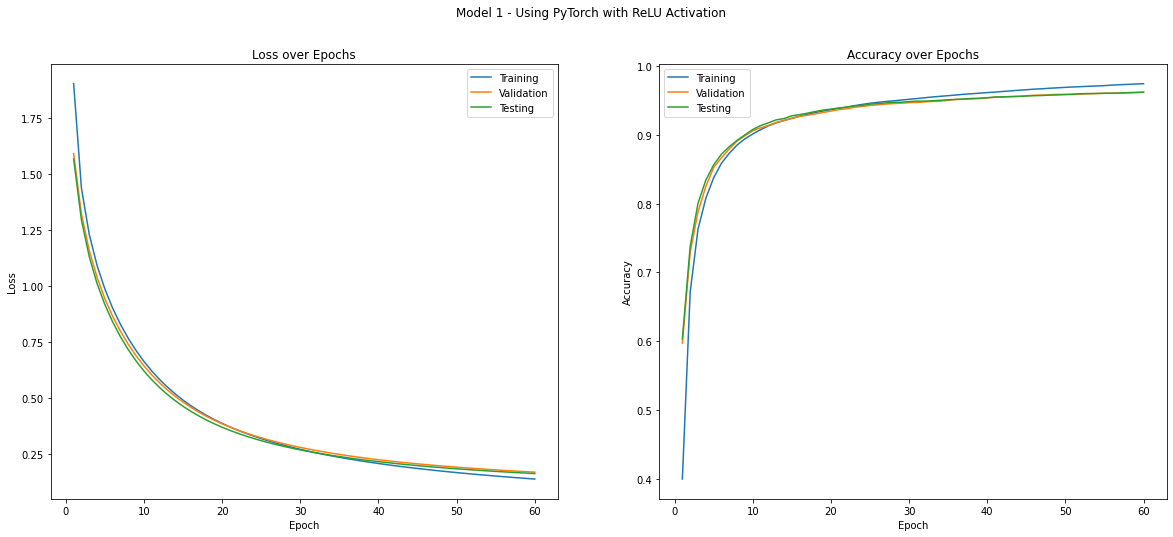

In [20]:
plt.figure(figsize=(20, 8))

## Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_loss, label='Training')
plt.plot(range(1, n_epochs + 1), val_loss, label='Validation')
plt.plot(range(1, n_epochs + 1), test_loss, label='Testing')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_acc, label='Training')
plt.plot(range(1, n_epochs + 1), val_acc, label='Validation')
plt.plot(range(1, n_epochs + 1), test_acc, label='Testing')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.tight_layout()
plt.suptitle("Model 1 - Using PyTorch with ReLU Activation")
plt.show()

### Scratch Implementation
The following classes and functions implement the FFN, ReLU activation, and Stochastic Gradient Descent from scratch without using the PyTorch modules.

This is the implementation of the activations - ReLU and LogSoftmax - functions used for this network.

In [21]:
class CustomReLU:
    def __init__(self):
        self.A = None
        self.Z = None

    def forward(self,Z):
        self.Z = Z
        self.A = self.Z.clone()
        self.A[self.Z<=0] = 0
        return self.A
    __call__ = forward

    def backward(self,dA):
        dZ = dA.clone()
        dZ[self.Z<=0] = 0
        return dZ
    

class CustomSigmoid:
    def __init__(self):
        self.A = None
        self.Z = None

    def forward(self,Z):
        self.Z = Z
        self.A = 1.0/(1.0 + torch.exp_(-1*Z))
        return self.A
    __call__=forward

    def backward(self,dA):
        dZ = dA * self.A*(1-self.A)/self.Z.size(0)
        return dZ


## Used log softmax for numerical stability
class CustomLogSoftmax:
    def forward(self,Z):
        Z_max,_ = torch.max(Z,dim=1,keepdim=True)
        Z = Z-Z_max

        expsum = torch.sum(torch.exp_(Z),dim=1,keepdim=True)
        out = Z - torch.log_(expsum)
        self.out = out
        
        return out
    __call__ = forward

    def backward(self,dZ):
        grad_Z = dZ * (1.-torch.exp_(self.out))
        return grad_Z

This is the implementation of the Linear layers and the Batch Normalization layers used for the network.

In [22]:
class CustomLinear:
    def __init__(self,n_in,n_out):
        ## Uses the Xavier initialization method for weights
        self.W = (torch.randn(n_in,n_out)*torch.sqrt(torch.tensor(4.0/(n_in+n_out)))).to(torch.float32)
        self.b = torch.zeros(n_out)
        ## Initialize all gradients to 0 initially
        self.dW = torch.zeros_like(self.W)
        self.db = torch.zeros_like(self.b)


    def forward(self,data):
        self.input = data
        self.output = (self.input@self.W).add_(self.b)
        return self.output
    __call__ = forward


    def backward(self, dZ):
        self.dW = (self.input.t())@dZ
        self.db = torch.sum(dZ,dim=0)
        self.dA = dZ@(self.W.t())
        return self.dA
    

class CustomBatchNormalization:
    def __init__(self,n_out,momentum=0.1):
        self.gamma = torch.ones(n_out)
        self.beta = torch.zeros(n_out)

        self.dgamma = torch.zeros(self.gamma.shape)
        self.dbeta = torch.zeros(self.beta.shape)

        self.mean = torch.tensor(0.0)
        self.var = torch.tensor(0.0)

        self.means = []
        self.vars = []

        self.mean_avg = torch.tensor(0.0)
        self.var_avg = torch.tensor(0.0)

        self.epsilon = 1e-10
        self.is_training = True
        self.momentum = momentum
        self.n = 0

    
    def forward(self, Z):
        self.Z = Z

        mean = torch.mean(Z,dim=0)
        self.mean = mean
        self.zmu = self.Z.add_(-1*self.mean)

        var = torch.var(Z,dim=0)
        self.var = var

        self.sqrtvar = torch.sqrt(var.add_(self.epsilon))
        self.ivar = 1./self.sqrtvar

        if self.is_training:
            self.Z_hat = self.zmu*self.ivar
            # self.mean_avg = (self.momentum)*self.mean_avg + (1.-self.momentum)*self.mean
            # self.var_avg = (self.momentum)*self.mean_avg + (1.-self.momentum)*self.var
            self.mean_avg = (self.n*self.mean_avg + self.mean)/(self.n+1)
            self.var_avg = (self.n*self.var_avg + self.var)/(self.n+1)
            self.n += 1
        else:
            self.Z_hat = (self.Z.add_(-1*self.mean_avg))/torch.sqrt(self.var_avg.add_(self.epsilon))

        output = (self.gamma*self.Z_hat).add_(self.beta)
        self.output = output
        return output

    __call__ = forward


    def backward(self,dA):
        self.dgamma = torch.sum(dA*self.Z_hat,dim=0)
        self.dbeta = torch.sum(dA,dim=0)

        m = self.Z.shape[0]
        dZ = (1./m)*(self.gamma*self.ivar)*((-self.dgamma*self.Z_hat)+m*dA-self.dbeta)
        return dZ


This is the implementation of the Feed Forward Network using the Linear and Batch Normalization layers.

In [23]:
class CustomFFN:
    def __init__(self,input_size,hidden_sizes,output_size,activation):
        self.layers = []

        for i in range(len(hidden_sizes)+1):
            in_size = input_size if i==0 else hidden_sizes[i-1]
            out_size = output_size if i==len(hidden_sizes) else hidden_sizes[i]

            self.layers.append(CustomLinear(in_size,out_size))
            if i!=(len(hidden_sizes)-1):
                self.layers.append(CustomBatchNormalization(out_size))

            act_layer = ((CustomSigmoid() if activation=='sigmoid' else CustomReLU()) if (i<(len(hidden_sizes))) else CustomLogSoftmax())
            self.layers.append(act_layer)


    def forward(self,data,train=True):
        X = data
        ## Iterate over hidden layers and apply to data
        for layer in self.layers:
            if isinstance(layer,CustomBatchNormalization):
                layer.is_training = train
            X = layer(X)
        return X
    __call__ = forward

This is the implementation of the Stochastic Gradient Descent optimizer.

In [24]:
class CustomSGD:
    def __init__(self,model,learning_rate,momentum=0.0):
        self.lr = learning_rate
        self.model = model
        self.momentum = momentum

    def step(self):
        for layer in reversed(self.model.layers):
            if isinstance(layer,CustomLinear):
                layer.W = layer.W - self.lr*layer.dW
                layer.b = layer.b - self.lr*layer.db
            elif isinstance(layer,CustomBatchNormalization):
                layer.gamma = layer.gamma - (self.lr*layer.dgamma)
                layer.beta = layer.beta - (self.lr*layer.dbeta)
            elif isinstance(layer,torch.nn.Linear):
                layer.weight.data = layer.weight.data - (self.lr*layer.weight.grad.data)
                layer.bias.data = layer.bias.data - (self.lr*layer.bias.grad.data)
            # elif isinstance(layer,torch.nn.BatchNorm1d):
                

    def zero_grad(self):
        for layer in self.model.layers:
            if isinstance(layer,CustomLinear):
                layer.dW.zero_()
                layer.db.zero_()
            elif isinstance(layer,CustomBatchNormalization):
                layer.dgamma.zero_()
                layer.dbeta.zero_()
            elif isinstance(layer,torch.nn.Linear):
                layer.zero_grad()
            elif isinstance(layer,torch.nn.BatchNorm1d):
                layer.zero_grad()

This is the implementation of the Cross Entropy Loss function.

In [100]:
class CustomCrossEntropyLoss:
    def __init__(self,model,n_classes):
        self.model = model
        self.n_classes = n_classes


    def _one_hot(self,y):
        res = torch.zeros([y.shape[0],self.n_classes])
        for i in range(y.shape[0]):
            res[i, y[i]] = 1
        return res

    
    def loss(self,y_hat,y):
        self.n = y.size(0)
        self.y = self._one_hot(y)
        preds = torch.exp_(y_hat)
        eps = torch.zeros_like(y_hat)+1e-10
        preds = torch.max(preds,eps)
        self.y_hat = preds

        l = torch.sum((self.y*y_hat),dim=1,keepdim=True)
        cost = -1*torch.mean(l)
        cost = torch.squeeze(cost)
        return cost
    __call__=loss
    

    def backward(self):
        dZ = (self.y/self.y_hat)/self.n
        d_out = dZ
        for idx,layer in enumerate(reversed(self.model.layers)):
            # if(idx==0): continue
            d_out = layer.backward(d_out)

In [101]:
model2 = CustomFFN(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=num_classes,
    activation='relu'
)
# model2.to(mps_device)

loss2 = CustomCrossEntropyLoss(model=model2,n_classes=num_classes)
optimizer2 = CustomSGD(model=model2,learning_rate=lr)

### Training Loop
The custom implemented FFN is trained on the same data with the same parameters as the PyTorch implementation.

In [102]:
train_loss,test_loss,val_loss,train_acc,test_acc,val_acc = [],[],[],[],[],[]

for epoch in range(n_epochs):
    correct = 0
    n_samples = 0
    total_loss = 0
    
    for idx,batch in enumerate(trainloader):
        optimizer2.zero_grad()
        data,labels = batch['data'],batch['label']
        # data = data.to(mps_device)
        # labels = labels.to(mps_device)

        inputs = data.view(data.size(0),-1).float()
        outputs = model2(inputs,True)
        l = loss2(outputs,labels)
        loss2.backward()
        optimizer2.step()

        _,pred = torch.max(outputs,dim=1)
        correct += (pred==labels).sum().item()
        n_samples += labels.size(0)
        total_loss += l.item()

    avg_train_l = total_loss/len(trainloader)
    train_a = correct/n_samples
    
    train_loss.append(avg_train_l)
    train_acc.append(train_a)

    
    correct = 0
    n_samples_test = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(testloader):
            testsamples,testlabels = batch['data'],batch['label']
            # testsamples = testsamples.to(mps_device)
            # testlabels = testlabels.to(mps_device)

            inputs = testsamples.view(testsamples.size(0),-1).float()
            testoutputs = model2(inputs,False)
            l = loss2(testoutputs,testlabels)

            _,pred = torch.max(testoutputs,1)
            correct += (pred==testlabels).sum().item()
            n_samples_test += len(testlabels)
            total_loss += l.item()

    avg_test_l = total_loss/len(testloader)
    test_a = correct/n_samples_test

    test_loss.append(avg_test_l)
    test_acc.append(test_a)


    correct = 0
    n_samples_val = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(valloader):
            valsamples,vallabels = batch['data'],batch['label']
            # valsamples = valsamples.to(mps_device)
            # vallabels = vallabels.to(mps_device)

            inputs = valsamples.view(valsamples.size(0),-1).float()
            valoutputs = model2(inputs,False)
            l = loss2(valoutputs,vallabels)
            
            _,pred = torch.max(valoutputs,1)
            correct += (pred==vallabels).sum().item()
            n_samples_val += len(vallabels)
            total_loss += l.item()

    avg_val_l = total_loss/len(valloader)
    val_a = correct/n_samples_val

    val_loss.append(avg_val_l)
    val_acc.append(val_a)

    print(f"Epoch {epoch+1}/{n_epochs}:\nTrain Loss: {avg_train_l}, Train Accuracy: {train_a}")
    print(f"Val Loss: {avg_val_l}, Val Accuracy: {val_a}\nTest Loss: {avg_test_l}, Test Accuracy: {test_a}\n")

Epoch 1/60:
Train Loss: -0.5229786270872101, Train Accuracy: 0.1972
Val Loss: -0.7303876039348071, Val Accuracy: 0.1785
Test Loss: -0.732165523722202, Test Accuracy: 0.1842

Epoch 2/60:
Train Loss: -0.7288722943162065, Train Accuracy: 0.43478
Val Loss: -0.8946602404872074, Val Accuracy: 0.3063
Test Loss: -0.9014570652684079, Test Accuracy: 0.3115

Epoch 3/60:
Train Loss: -0.9134135279813995, Train Accuracy: 0.57778
Val Loss: -1.041945989373364, Val Accuracy: 0.3946
Test Loss: -1.0517258908175215, Test Accuracy: 0.401

Epoch 4/60:
Train Loss: -1.0737408498668914, Train Accuracy: 0.65974
Val Loss: -1.1726999305471588, Val Accuracy: 0.4573
Test Loss: -1.185558419438857, Test Accuracy: 0.4677

Epoch 5/60:
Train Loss: -1.218216286900708, Train Accuracy: 0.7091
Val Loss: -1.2900771966463402, Val Accuracy: 0.5037
Test Loss: -1.3081873806217048, Test Accuracy: 0.5183

Epoch 6/60:
Train Loss: -1.3523440964691473, Train Accuracy: 0.74384
Val Loss: -1.3997093590000007, Val Accuracy: 0.5451
Test L

KeyboardInterrupt: 

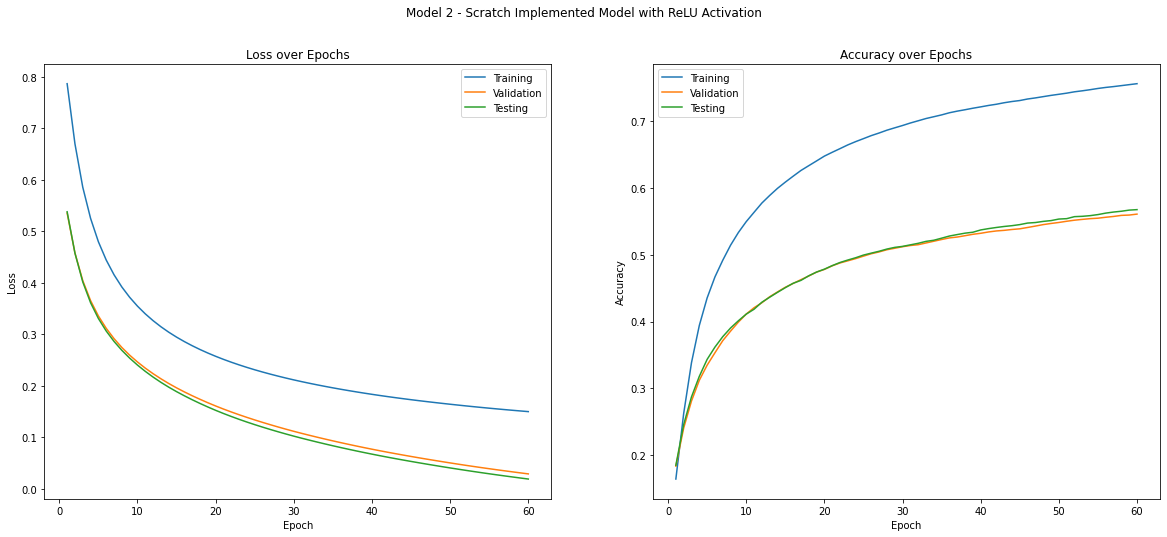

In [ ]:
plt.figure(figsize=(20, 8))

## Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_loss, label='Training')
plt.plot(range(1, n_epochs + 1), val_loss, label='Validation')
plt.plot(range(1, n_epochs + 1), test_loss, label='Testing')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_acc, label='Training')
plt.plot(range(1, n_epochs + 1), val_acc, label='Validation')
plt.plot(range(1, n_epochs + 1), test_acc, label='Testing')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.tight_layout()
plt.suptitle("Model 2 - Scratch Implemented Model with ReLU Activation")
plt.show()

### Sigmoid Activation
The following is the performance report of each of the 2 architectures with sigmoid activations instead of ReLU activations.

In [ ]:
model3 = FeedForwardNN(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    activation=torch.nn.Sigmoid()
)
# model3.to(mps_device)

loss3 = torch.nn.CrossEntropyLoss()
optimizer3 = torch.optim.SGD(params=model3.parameters(),lr=lr)

In [ ]:
train_loss,test_loss,val_loss,train_acc,test_acc,val_acc = [],[],[],[],[],[]

for epoch in range(n_epochs):
    model3.train(mode=True)
    correct = 0
    n_samples = 0
    total_loss = 0

    for idx,batch in enumerate(trainloader):
        optimizer3.zero_grad()
        data,labels = batch['data'],batch['label']
        # data = data.to(mps_device)
        # labels = labels.to(mps_device)

        inputs = data.view(data.size(0),-1).float()
        outputs = model3(inputs)
        l = loss3(outputs,labels)
        l.backward()
        optimizer3.step()

        _,pred = torch.max(outputs,dim=1)
        correct += (pred==labels).sum().item()
        n_samples += labels.size(0)
        total_loss += l.item()

    avg_train_l = total_loss/len(trainloader)
    train_a = correct/n_samples

    train_loss.append(avg_train_l)
    train_acc.append(train_a)


    model3.train(mode=False)
    correct = 0
    n_samples_test = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(testloader):
            testsamples,testlabels = batch['data'],batch['label']
            # testsamples = testsamples.to(mps_device)
            # testlabels = testlabels.to(mps_device)

            inputs = testsamples.view(testsamples.size(0),-1).float()
            testoutputs = model3(inputs)
            l = loss3(testoutputs,testlabels)

            _,pred = torch.max(testoutputs,1)
            correct += (pred==testlabels).sum().item()
            n_samples_test += len(testlabels)
            total_loss += l.item()

    avg_test_l = total_loss/len(testloader)
    test_a = correct/n_samples_test

    test_loss.append(avg_test_l)
    test_acc.append(test_a)


    model3.train(mode=False)
    correct = 0
    n_samples_val = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(valloader):
            valsamples,vallabels = batch['data'],batch['label']
            # valsamples = valsamples.to(mps_device)
            # vallabels = vallabels.to(mps_device)

            inputs = valsamples.view(valsamples.size(0),-1).float()
            valoutputs = model3(inputs)
            l = loss3(valoutputs,vallabels)

            _,pred = torch.max(valoutputs,1)
            correct += (pred==vallabels).sum().item()
            n_samples_val += len(vallabels)
            total_loss += l.item()


    avg_val_l = total_loss/len(valloader)
    val_a = correct/n_samples_val

    val_loss.append(avg_val_l)
    val_acc.append(val_a)


    print(f"Epoch {epoch+1}/{n_epochs}:\nTrain Loss: {avg_train_l}, Train Accuracy: {train_a}")
    print(f"Val Loss: {avg_val_l}, Val Accuracy: {val_a}\nTest Loss: {avg_test_l}, Test Accuracy: {test_a}\n")


Epoch 1/60:
Train Loss: 1.9059699667079368, Train Accuracy: 0.3842
Val Loss: 1.5520688793327235, Val Accuracy: 0.5925
Test Loss: 1.534454484529133, Test Accuracy: 0.5958

Epoch 2/60:
Train Loss: 1.4112759426121821, Train Accuracy: 0.66222
Val Loss: 1.2817761988579472, Val Accuracy: 0.7275
Test Loss: 1.255472022521345, Test Accuracy: 0.7333

Epoch 3/60:
Train Loss: 1.2040628036269752, Train Accuracy: 0.75584
Val Loss: 1.123420870002312, Val Accuracy: 0.7883
Test Loss: 1.0932138916812366, Test Accuracy: 0.7976

Epoch 4/60:
Train Loss: 1.0686377020138305, Train Accuracy: 0.80514
Val Loss: 1.0091788399068615, Val Accuracy: 0.8249
Test Loss: 0.9776220321655273, Test Accuracy: 0.8375

Epoch 5/60:
Train Loss: 0.9662393686716514, Train Accuracy: 0.83694
Val Loss: 0.9191100205047221, Val Accuracy: 0.8509
Test Loss: 0.8874264725401432, Test Accuracy: 0.8615

Epoch 6/60:
Train Loss: 0.8832678130215696, Train Accuracy: 0.85758
Val Loss: 0.8442069910749604, Val Accuracy: 0.8652
Test Loss: 0.8130741

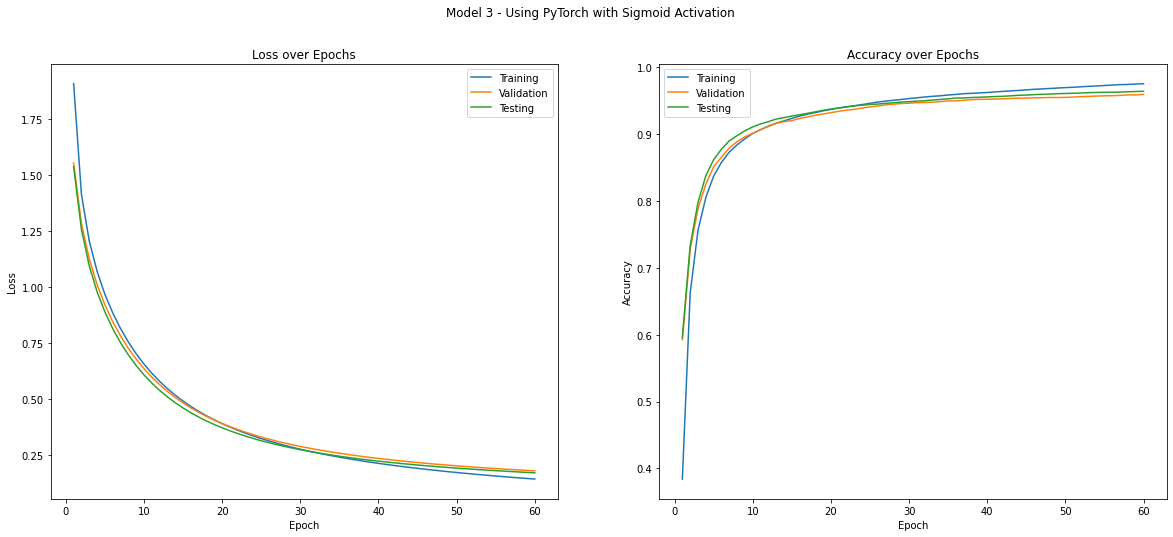

In [ ]:
plt.figure(figsize=(20, 8))

## Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_loss, label='Training')
plt.plot(range(1, n_epochs + 1), val_loss, label='Validation')
plt.plot(range(1, n_epochs + 1), test_loss, label='Testing')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_acc, label='Training')
plt.plot(range(1, n_epochs + 1), val_acc, label='Validation')
plt.plot(range(1, n_epochs + 1), test_acc, label='Testing')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.tight_layout()
plt.suptitle("Model 3 - Using PyTorch with Sigmoid Activation")
plt.show()

In [ ]:
model4 = CustomFFN(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=num_classes,
    activation='sigmoid'
)
# model2.to(mps_device)

loss4 = CustomCrossEntropyLoss(model=model4,n_classes=num_classes)
optimizer4 = CustomSGD(model=model4,learning_rate=lr+0.1)

In [ ]:
train_loss,test_loss,val_loss,train_acc,test_acc,val_acc = [],[],[],[],[],[]

for epoch in range(n_epochs):
    correct = 0
    n_samples = 0
    total_loss = 0
    
    for idx,batch in enumerate(trainloader):
        optimizer4.zero_grad()
        data,labels = batch['data'],batch['label']
        # data = data.to(mps_device)
        # labels = labels.to(mps_device)

        inputs = data.view(data.size(0),-1).float()
        outputs = model4(inputs,True)
        l = loss4(outputs,labels)
        loss4.backward()
        optimizer4.step()

        _,pred = torch.max(outputs,dim=1)
        correct += (pred==labels).sum().item()
        n_samples += labels.size(0)
        total_loss += l.item()

    avg_train_l = total_loss/len(trainloader)
    train_a = correct/n_samples
    
    train_loss.append(avg_train_l)
    train_acc.append(train_a)

    
    correct = 0
    n_samples_test = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(testloader):
            testsamples,testlabels = batch['data'],batch['label']
            # testsamples = testsamples.to(mps_device)
            # testlabels = testlabels.to(mps_device)

            inputs = testsamples.view(testsamples.size(0),-1).float()
            testoutputs = model4(inputs,False)
            l = loss4(testoutputs,testlabels)

            _,pred = torch.max(testoutputs,1)
            correct += (pred==testlabels).sum().item()
            n_samples_test += len(testlabels)
            total_loss += l.item()

    avg_test_l = total_loss/len(testloader)
    test_a = correct/n_samples_test

    test_loss.append(avg_test_l)
    test_acc.append(test_a)


    correct = 0
    n_samples_val = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(valloader):
            valsamples,vallabels = batch['data'],batch['label']
            # valsamples = valsamples.to(mps_device)
            # vallabels = vallabels.to(mps_device)

            inputs = valsamples.view(valsamples.size(0),-1).float()
            valoutputs = model4(inputs,False)
            l = loss4(valoutputs,vallabels)
            
            _,pred = torch.max(valoutputs,1)
            correct += (pred==vallabels).sum().item()
            n_samples_val += len(vallabels)
            total_loss += l.item()

    avg_val_l = total_loss/len(valloader)
    val_a = correct/n_samples_val

    val_loss.append(avg_val_l)
    val_acc.append(val_a)

    print(f"Epoch {epoch+1}/{n_epochs}:\nTrain Loss: {avg_train_l}, Train Accuracy: {train_a}")
    print(f"Val Loss: {avg_val_l}, Val Accuracy: {val_a}\nTest Loss: {avg_test_l}, Test Accuracy: {test_a}\n")

Epoch 1/60:
Train Loss: 0.4233935983360881, Train Accuracy: 0.4056
Val Loss: -0.10131635299966305, Val Accuracy: 0.1014
Test Loss: -0.09666788153633286, Test Accuracy: 0.0974

Epoch 2/60:
Train Loss: 0.06613858083508375, Train Accuracy: 0.20444
Val Loss: -0.10121169259559505, Val Accuracy: 0.1014
Test Loss: -0.09655816631415222, Test Accuracy: 0.0974

Epoch 3/60:
Train Loss: -0.07604919141947465, Train Accuracy: 0.08058
Val Loss: -0.06458418302332299, Val Accuracy: 0.0969
Test Loss: -0.06262385144924061, Test Accuracy: 0.0962

Epoch 4/60:
Train Loss: -0.09066923605301953, Train Accuracy: 0.09078
Val Loss: -0.056635327884762346, Val Accuracy: 0.0739
Test Loss: -0.05408590915907599, Test Accuracy: 0.0729

Epoch 5/60:
Train Loss: -0.09309494361052732, Train Accuracy: 0.09312
Val Loss: -0.06720044246957271, Val Accuracy: 0.0712
Test Loss: -0.06378102276615705, Test Accuracy: 0.0682

Epoch 6/60:
Train Loss: -0.09226743699244373, Train Accuracy: 0.0923
Val Loss: -0.05409031861779999, Val Acc

KeyboardInterrupt: 

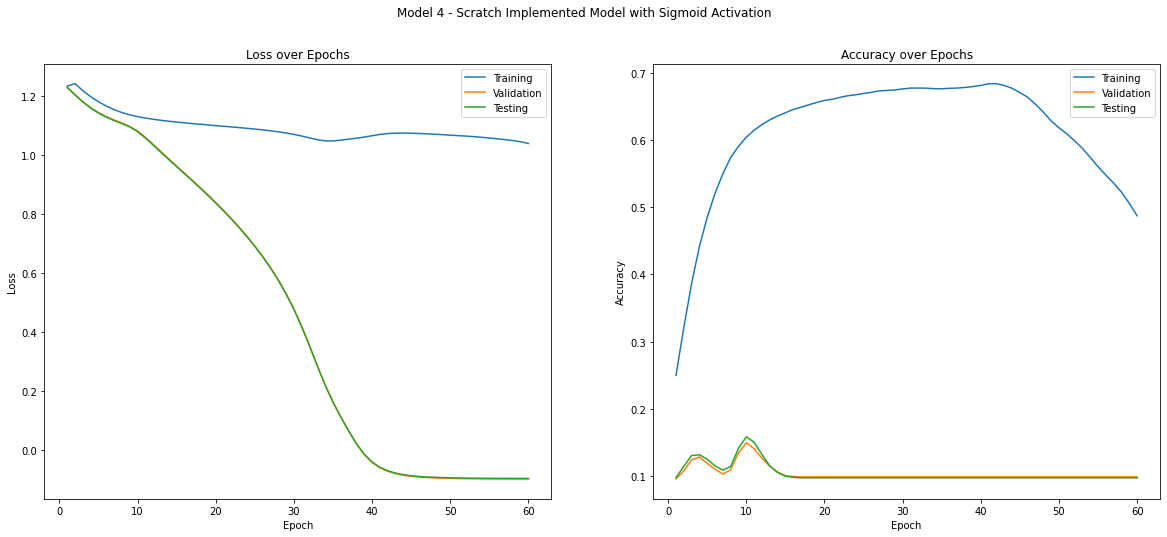

In [ ]:
plt.figure(figsize=(20, 8))

## Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_loss, label='Training')
plt.plot(range(1, n_epochs + 1), val_loss, label='Validation')
plt.plot(range(1, n_epochs + 1), test_loss, label='Testing')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_acc, label='Training')
plt.plot(range(1, n_epochs + 1), val_acc, label='Validation')
plt.plot(range(1, n_epochs + 1), test_acc, label='Testing')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.tight_layout()
plt.suptitle("Model 4 - Scratch Implemented Model with Sigmoid Activation")
plt.show()